In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import zipfile
import json
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

2026-02-25 08:55:49.481823: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1772009749.686761      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1772009749.735806      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1772009750.234469      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1772009750.234512      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1772009750.234515      55 computation_placer.cc:177] computation placer alr

In [3]:
# Suppress annoying TensorFlow warning logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# ==========================================
# 1. DOWNLOAD & EXTRACT DATASET (Mendeley)
# ==========================================
dataset_url = "https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/d5652a28-c1d8-4b76-97f3-72fb80f94efc/file_downloaded"
zip_path = "plant_dataset.zip"
extract_path = "./plant_dataset"

if not os.path.exists(zip_path):
    print("📥 Downloading dataset from Mendeley...")
    os.system(f"wget {dataset_url} -O {zip_path}")
else:
    print("✅ Dataset archive already exists.")

if not os.path.exists(extract_path):
    print("📂 Extracting files... (This may take a moment)")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
else:
    print("✅ Dataset already extracted.")

def find_data_root(base):
    """Finds the actual folder containing the class subdirectories."""
    for root, dirs, files in os.walk(base):
        if len(dirs) > 30: 
            return root 
    return base

DATA_DIR = find_data_root(extract_path)
print(f"🎯 DATA_DIR is set to: {DATA_DIR}")

📥 Downloading dataset from Mendeley...


--2026-02-25 08:56:14--  https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/d5652a28-c1d8-4b76-97f3-72fb80f94efc/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.133.86, 162.159.130.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.133.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/d29ed9b2-8a5d-4663-8a82-c9174f2c7066 [following]
--2026-02-25 08:56:15--  https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/d29ed9b2-8a5d-4663-8a82-c9174f2c7066
Resolving prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)... 52.92.35.138, 52.218.118.98, 3.5.71.77, ...
Connecting to prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)|52.92.35.138|:443..

📂 Extracting files... (This may take a moment)
🎯 DATA_DIR is set to: ./plant_dataset/Plant_leave_diseases_dataset_without_augmentation


In [4]:
# ==========================================
# 2. DATA PREPROCESSING & GENERATORS
# ==========================================
print("⏳ Preparing Data Generators...")
train_datagen = ImageDataGenerator(
    rescale=1./255,        # Normalize pixels to 0-1
    rotation_range=20,     # Augmentation: Rotate
    zoom_range=0.2,        # Augmentation: Zoom
    horizontal_flip=True,  # Augmentation: Flip
    validation_split=0.2   # 80% Train, 20% Validation
)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Dynamically get the exact number of classes to prevent Shape errors
NUM_CLASSES = len(train_generator.class_indices)
print(f"🔍 Found {NUM_CLASSES} classes in the dataset.")

⏳ Preparing Data Generators...
Found 44371 images belonging to 39 classes.
Found 11077 images belonging to 39 classes.
🔍 Found 39 classes in the dataset.


In [5]:
# ==========================================
# 3. BUILD AI MODEL (MobileNetV2 Transfer Learning)
# ==========================================
print("🧠 Building the Neural Network...")
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False # Freeze pre-trained base layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x) # Prevent overfitting
predictions = Dense(NUM_CLASSES, activation='softmax')(x) # Dynamic output layer

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy']
             )

🧠 Building the Neural Network...


/tmp/ipykernel_55/1042141735.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
I0000 00:00:1772009835.210283      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1772009835.216453      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
# ==========================================
# 4. CALLBACKS & TRAINING
# ==========================================
checkpoint = ModelCheckpoint("plant_cnn_model.h5", 
                             monitor='val_accuracy', 
                             save_best_only=True, 
                             verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3, 
                               restore_best_weights=True, 
                               verbose=1)

EPOCHS = 10
print(f"🚀 Starting training for {EPOCHS} epochs...")

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stopping]
)

print("✅ Training Complete!")

🚀 Starting training for 10 epochs...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1772009844.050904     139 service.cc:152] XLA service 0x7a3ff4002a00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1772009844.050937     139 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1772009844.050943     139 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1772009845.112798     139 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-02-25 08:57:33.523731: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-25 08:57:33.661563: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
I0000 00:00:1772009855.718285     139 device_co

 115/1387 ━━━━━━━━━━━━━━━━━━━━ 8:52 418ms/step - accuracy: 0.3432 - loss: 2.6765

2026-02-25 08:58:33.720298: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-25 08:58:33.879901: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-25 08:58:34.016818: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1387/1387 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.7513 - loss: 0.9822

2026-02-25 09:10:29.230290: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-25 09:10:29.366828: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



Epoch 1: val_accuracy improved from -inf to 0.92633, saving model to plant_cnn_model.h5


1387/1387 ━━━━━━━━━━━━━━━━━━━━ 795s 560ms/step - accuracy: 0.7514 - loss: 0.9819 - val_accuracy: 0.9263 - val_loss: 0.2434
Epoch 2/10
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.9270 - loss: 0.2414
Epoch 2: val_accuracy improved from 0.92633 to 0.94141, saving model to plant_cnn_model.h5


1387/1387 ━━━━━━━━━━━━━━━━━━━━ 744s 537ms/step - accuracy: 0.9270 - loss: 0.2414 - val_accuracy: 0.9414 - val_loss: 0.1850
Epoch 3/10
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.9391 - loss: 0.1942
Epoch 3: val_accuracy improved from 0.94141 to 0.94737, saving model to plant_cnn_model.h5


1387/1387 ━━━━━━━━━━━━━━━━━━━━ 743s 536ms/step - accuracy: 0.9391 - loss: 0.1942 - val_accuracy: 0.9474 - val_loss: 0.1648
Epoch 4/10
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.9431 - loss: 0.1752
Epoch 4: val_accuracy did not improve from 0.94737
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 709s 511ms/step - accuracy: 0.9431 - loss: 0.1752 - val_accuracy: 0.9443 - val_loss: 0.1690
Epoch 5/10
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.9452 - loss: 0.1635
Epoch 5: val_accuracy did not improve from 0.94737
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 690s 497ms/step - accuracy: 0.9452 - loss: 0.1635 - val_accuracy: 0.9464 - val_loss: 0.1589
Epoch 6/10
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.9488 - loss: 0.1540
Epoch 6: val_accuracy improved from 0.94737 to 0.94944, saving model to plant_cnn_model.h5


1387/1387 ━━━━━━━━━━━━━━━━━━━━ 673s 485ms/step - accuracy: 0.9488 - loss: 0.1540 - val_accuracy: 0.9494 - val_loss: 0.1533
Epoch 7/10
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.9491 - loss: 0.1543
Epoch 7: val_accuracy improved from 0.94944 to 0.95188, saving model to plant_cnn_model.h5


1387/1387 ━━━━━━━━━━━━━━━━━━━━ 726s 524ms/step - accuracy: 0.9491 - loss: 0.1543 - val_accuracy: 0.9519 - val_loss: 0.1409
Epoch 8/10
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.9498 - loss: 0.1496
Epoch 8: val_accuracy did not improve from 0.95188
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 736s 530ms/step - accuracy: 0.9498 - loss: 0.1496 - val_accuracy: 0.9511 - val_loss: 0.1481
Epoch 9/10
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.9512 - loss: 0.1449
Epoch 9: val_accuracy improved from 0.95188 to 0.95215, saving model to plant_cnn_model.h5


1387/1387 ━━━━━━━━━━━━━━━━━━━━ 717s 517ms/step - accuracy: 0.9512 - loss: 0.1449 - val_accuracy: 0.9522 - val_loss: 0.1406
Epoch 10/10
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.9523 - loss: 0.1389
Epoch 10: val_accuracy improved from 0.95215 to 0.95703, saving model to plant_cnn_model.h5


1387/1387 ━━━━━━━━━━━━━━━━━━━━ 712s 514ms/step - accuracy: 0.9523 - loss: 0.1389 - val_accuracy: 0.9570 - val_loss: 0.1298
Restoring model weights from the end of the best epoch: 10.
✅ Training Complete!


In [7]:
# ==========================================
# 5. SAVE LABELS FOR FLASK APP
# ==========================================
class_indices = train_generator.class_indices
class_names_dict = {v: k for k, v in class_indices.items()}

with open("class_names.json", "w") as f:
    json.dump(class_names_dict, f, indent=4)
print("✅ Saved class_names.json successfully.")

✅ Saved class_names.json successfully.


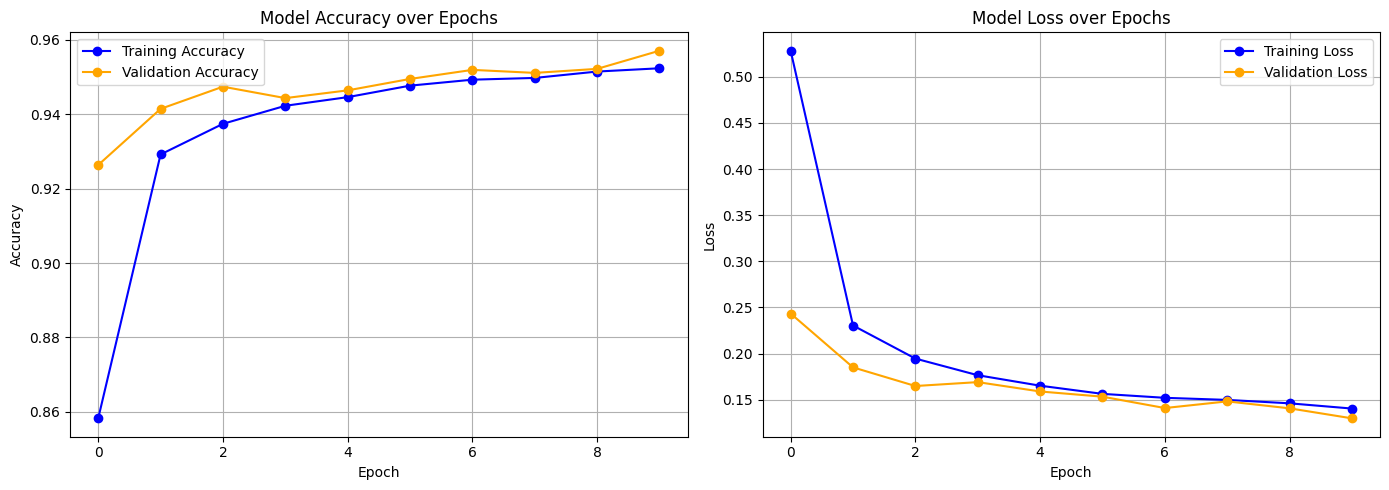

In [8]:
# ==========================================
# 6. PLOT RESULTS
# ==========================================
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', marker='o')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='blue', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', marker='o')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()